In [1]:
from matplotlib.ticker import FuncFormatter
from scipy.stats import skew

import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

### Read Input Data

In [2]:
raw_registration_df = pd.read_csv('2025 50K Registration.csv', dtype={
    'Sex': 'category'
})

In [3]:
raw_finishers_df = pd.read_csv('Lakefront March 50K Data 2019-2025.csv', dtype={
    'Age': 'Int64', # Nullable integer
    'Sex Place': 'Int64',
    'Division Place': 'Int64',
    'Race Number': 'string',
    'Sex': 'category'
})

### Clean Data

In [4]:
raw_registration_df['Date of Registration'] = pd.to_datetime(raw_registration_df['Date of Registration'], format='%Y-%m-%d')
raw_registration_df['Race Date'] = pd.to_datetime(raw_registration_df['Race Date'], format='%Y-%m-%d')
raw_registration_df.head(1)

,Order of Registration,Race Number,Name,Age,Sex,State,Hometown,Date of Registration,Race Date
0,89,120,Paul Garcia,51,M,Illinois,Skokie,2025-03-29,2025-03-29


In [5]:
# Make a copy
cleaned_finishers_df = raw_finishers_df.copy()

# Convert Race Date to datetime format
cleaned_finishers_df['Race Date'] = pd.to_datetime(cleaned_finishers_df['Race Date'], format='%Y-%m-%d')
cleaned_finishers_df['Year'] = cleaned_finishers_df['Race Date'].dt.year

# Convert Pace to timedelta format, since they represent duration
cleaned_finishers_df['Pace'] = pd.to_timedelta('00:' + cleaned_finishers_df['Pace'])
cleaned_finishers_df['Pace (seconds)'] = cleaned_finishers_df['Pace'].dt.total_seconds()

# Convert Finish Time from 'HH:MM' string to timedelta for ease of calculations (mean, std, etc.)
cleaned_finishers_df['Time'] = pd.to_timedelta(cleaned_finishers_df['Time'] + ':00')
cleaned_finishers_df['Finish Time (seconds)'] = cleaned_finishers_df['Time'].dt.total_seconds()

# Convert to title case
cleaned_finishers_df['Hometown'] = cleaned_finishers_df['Hometown'].str.title() # i.e. "new york" → "New York", "CHICAGO" → "Chicago"
cleaned_finishers_df['Hometown'] = cleaned_finishers_df['Hometown'].str.replace('Hts', 'Heights', regex=False)

# Convert to upper case
cleaned_finishers_df['State'] = cleaned_finishers_df['State'].str.upper()

# Clean Age Group data
cleaned_finishers_df['Division'] = cleaned_finishers_df['Division'].str.replace('Male ', '', regex=False)
cleaned_finishers_df['Division'] = cleaned_finishers_df['Division'].str.replace('Female ', '', regex=False)

cleaned_finishers_df.head(1)

,Overall Place,Name,Age,Sex,Sex Place,Division,Division Place,Time,Pace,State,Hometown,Race Number,Race Date,Year,Pace (seconds),Finish Time (seconds)
0,1,Chris Dybas,21,M,1,18 - 29,1,0 days 04:01:00,0 days 00:07:46.400000,IL,Lagrange,24,2025-03-29,2025,466.4,14460.0


## Analysis

In [6]:
# Define age group bins
age_bins = [0, 29, 39, 49, 59, 69, 79, 150]
age_labels = ['18 - 29', '30 - 39', '40 - 49', '50 - 59', '60 - 69', '70 - 79', '80 - Up']

# Create Age Group column
raw_registration_df['Division'] = pd.cut(raw_registration_df['Age'], bins=age_bins, labels=age_labels, right=True)
raw_registration_df['Division'] = pd.Categorical(raw_registration_df['Division'], ordered=True)

registrants_count_by_sex = (raw_registration_df.groupby('Sex', observed=True)['Race Number'].count()
                        .reset_index(name='Registrants Count') # turn the count result back into a df with named columns
                     )
registrants_count_by_sex

,Sex,Registrants Count
0,F,23
1,M,66


In [7]:
registrants_count_breakdown = (raw_registration_df.groupby(['Division', 'Sex'], observed=True).size()
                               .unstack().reset_index()
                              )
registrants_count_breakdown

Sex,Division,F,M
0,18 - 29,4.0,11.0
1,30 - 39,4.0,10.0
2,40 - 49,11.0,22.0
3,50 - 59,1.0,13.0
4,60 - 69,3.0,8.0
5,70 - 79,NaN,1.0
6,80 - Up,NaN,1.0


In [8]:
# Get 2025 data only
finishers_2025_df = cleaned_finishers_df[cleaned_finishers_df['Year']==2025].copy()
finishers_2025_df['Division'] = pd.Categorical(finishers_2025_df['Division'], ordered=True)

finishers_2025_count_by_sex = (finishers_2025_df.groupby('Sex', observed=True)['Race Number'].count()
                        .reset_index(name='Finishers Count') # turn the count result back into a df with named columns
                     )
finishers_2025_count_by_sex

,Sex,Finishers Count
0,F,19
1,M,53


In [52]:
finishers_count_breakdown = (finishers_2025_df.groupby(['Division', 'Sex'], observed=True).size()
                               .unstack().reset_index()
                               )
# Insert 70-79 age group to match registrants df
new_row = pd.DataFrame({'Division': ['70 - 79'], 'F': [np.nan], 'M': [np.nan]})

# Insert at row position 5
finishers_count_breakdown = pd.concat([finishers_count_breakdown.iloc[:5], new_row, finishers_count_breakdown.iloc[5:]], ignore_index=True)

finishers_count_breakdown

,Division,F,M
0,18 - 29,3.0,8.0
1,30 - 39,3.0,7.0
2,40 - 49,9.0,19.0
3,50 - 59,1.0,12.0
4,60 - 69,3.0,6.0
5,70 - 79,NaN,NaN
6,80 - Up,NaN,1.0


### Finisher Count

In [53]:
summary_df = pd.merge(finishers_2025_count_by_sex, registrants_count_by_sex, on='Sex')
summary_df['Non-Finishers Count'] = summary_df['Registrants Count'] - summary_df['Finishers Count']

summary_df['% Finishers'] = (summary_df['Finishers Count'] / summary_df['Registrants Count']) * 100
summary_df['% Finishers'] = summary_df['% Finishers'].round(1)

summary_df

,Sex,Finishers Count,Registrants Count,Non-Finishers Count,% Finishers
0,F,19,23,4,82.6
1,M,53,66,13,80.3


In [54]:
# Resets all Matplotlib settings (colors, fonts, figure size, etc.) back to their default values
plt.rcParams.update(plt.rcParamsDefault)
# Render all plots inside the notebook, not in a separate window.
%matplotlib inline
# Applies a predefined Matplotlib style 
plt.style.use('fast') #fivethirtyeight

### Registrant Details

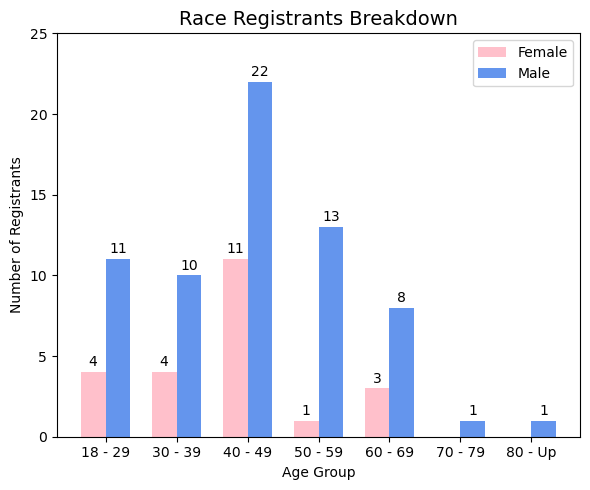

In [59]:
# Positions for bars
x = np.arange(len(registrants_count_breakdown['Division']))  # the label locations
width = 0.35  # width of the bars

# Plot
fig, ax = plt.subplots(figsize=(6, 5))
bars1 = ax.bar(x - width/2, registrants_count_breakdown['F'], width, label='Female', color='pink')
bars2 = ax.bar(x + width/2, registrants_count_breakdown['M'],  width, label='Male', color='cornflowerblue')

ax.bar_label(bars1, padding=2)
ax.bar_label(bars2, padding=2)

ax.set_xticks(x)
ax.set_xticklabels(registrants_count_breakdown['Division'])
ax.set_yticks([0, 5, 10, 15, 20, 25])

# Labels and styling
ax.set_title('Race Registrants Breakdown', fontsize=14)
ax.set_ylabel('Number of Registrants')
ax.set_xlabel('Age Group')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig("Race Registrants Breakdown Bar Chart.png", dpi=300, bbox_inches='tight')  # High resolution, no extra whitespace
plt.show()

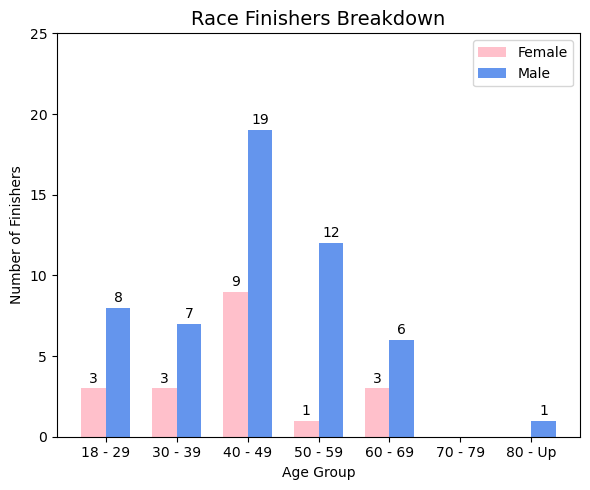

In [60]:
# Positions for bars
x = np.arange(len(finishers_count_breakdown['Division']))  # the label locations
width = 0.35  # width of the bars

# Plot
fig, ax = plt.subplots(figsize=(6, 5))
bars1 = ax.bar(x - width/2, finishers_count_breakdown['F'], width, label='Female', color='pink')
bars2 = ax.bar(x + width/2, finishers_count_breakdown['M'],  width, label='Male', color='cornflowerblue')

ax.bar_label(bars1, padding=2)
ax.bar_label(bars2, padding=2)

ax.set_xticks(x)
ax.set_xticklabels(finishers_count_breakdown['Division'])
ax.set_yticks([0, 5, 10, 15, 20, 25])

# Labels and styling
ax.set_title('Race Finishers Breakdown', fontsize=14)
ax.set_ylabel('Number of Finishers')
ax.set_xlabel('Age Group')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig("Race Finishers Breakdown Bar Chart.png", dpi=300, bbox_inches='tight')  # High resolution, no extra whitespace
plt.show()

## Finisher vs Non-Finisher Count by Gender

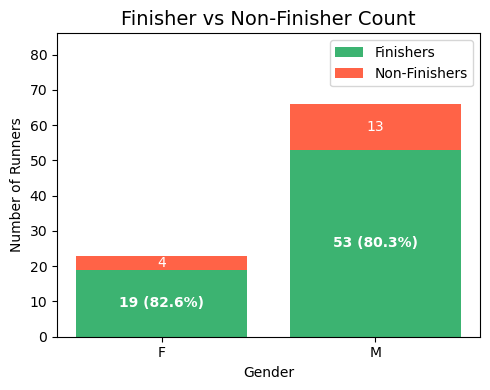

In [61]:
# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(5, 4))

# Plot finishers
ax.bar(summary_df['Sex'], summary_df['Finishers Count'],
       label='Finishers', color='mediumseagreen')

# Plot non-finishers stacked on top
ax.bar(summary_df['Sex'], summary_df['Non-Finishers Count'], bottom=summary_df['Finishers Count'],
       label='Non-Finishers', color='tomato')

# Add data labels with percentages
for i, row in summary_df.iterrows():
    # Finishers with %
    ax.text(row['Sex']
            , row['Finishers Count'] / 2
            , f"{row['Finishers Count']} ({row['% Finishers']:.1f}%)"
            , ha='center', va='center', color='white', fontsize=10, fontweight='bold'
           )
    # Non-Finishers
    ax.text(row['Sex']
            , row['Finishers Count'] + row['Non-Finishers Count'] / 2
            , str(row['Non-Finishers Count'])
            , ha='center', va='center', color='white', fontsize=10
           )

# Labels and title
ax.set_title('Finisher vs Non-Finisher Count', fontsize=14)
ax.set_ylabel('Number of Runners')
ax.set_xlabel('Gender')
ax.legend(loc="upper right")
ax.set_ylim(0, summary_df['Registrants Count'].max() + 20)

plt.tight_layout()
plt.savefig("Finishers v Non-Finishers Count Bar Chart.png", dpi=300, bbox_inches='tight')  # High resolution, no extra whitespace
plt.show()

In [13]:
finish_time_stats_by_sex = finishers_2025_df.groupby('Sex', observed=True)['Time'].agg(
    Average_Finish_Time='mean',
    Median_Finish_Time='median',
    Fastest_Finish_Time='min',
    Std_Dev_Finish_Time='std'
).reset_index()

# finish_time_stats_by_sex = finishers_2025_df.groupby('Sex', observed=True)['Finish Time (seconds)'].agg(
#     Average_Finish_Time='mean',
#     Median_Finish_Time='median',
#     Fastest_Finish_Time='min',
#     Std_Dev_Finish_Time='std'
# ).reset_index()

finish_time_stats_by_sex

,Sex,Average_Finish_Time,Median_Finish_Time,Fastest_Finish_Time,Std_Dev_Finish_Time
0,F,0 days 06:05:53.684210526,0 days 05:49:00,0 days 04:21:00,0 days 01:31:08.524288575
1,M,0 days 06:01:22.641509433,0 days 05:49:00,0 days 04:01:00,0 days 01:18:06.832681091


In [14]:
# Finish time statistics
# Female finishers
female_finishers = finishers_2025_df[finishers_2025_df['Sex'] == 'F']
female_median = female_finishers['Finish Time (seconds)'].median()
female_mean = female_finishers['Finish Time (seconds)'].mean()
female_skew = skew(female_finishers['Finish Time (seconds)'])

# Male finishers
male_finishers = finishers_2025_df[finishers_2025_df['Sex'] == 'M']
male_median = male_finishers['Finish Time (seconds)'].median()
male_mean = male_finishers['Finish Time (seconds)'].mean()
male_skew = skew(male_finishers['Finish Time (seconds)'])

### Finishing Time Quartile Box Plot

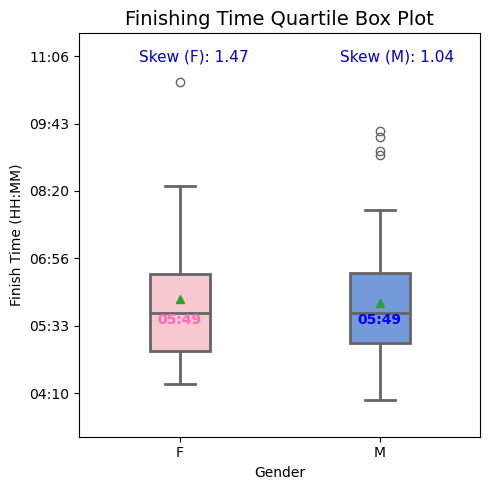

In [69]:
# Create boxplot
fig, ax = plt.subplots(figsize=(5,5))

sns.boxplot(data=finishers_2025_df, x='Sex', y='Finish Time (seconds)'
            , palette={'M': 'cornflowerblue', 'F': 'pink'}, showmeans=True
            , hue='Sex', legend=False, linewidth=2, width=0.3, ax=ax)

# Set y-axis upper limit for spacing
y_max = finishers_2025_df['Finish Time (seconds)'].max() + 3600  # 1 hour
y_min = finishers_2025_df['Finish Time (seconds)'].min() - 2700  # 45 mins
ax.set_ylim(y_min, y_max)

# Add skewness annotation near top of the chart
ax.text(0.8, y_max * 0.95, f"Skew (M): {male_skew:.2f}", fontsize=11, color='mediumblue')
ax.text(-0.2, y_max * 0.95, f"Skew (F): {female_skew:.2f}", fontsize=11, color='mediumblue')

# Convert y-axis to HH:MM format
def seconds_to_hhmm(x, pos=None):
    hours = int(x // 3600)
    minutes = int((x % 3600) // 60)
    return f'{hours:02d}:{minutes:02d}'
ax.yaxis.set_major_formatter(FuncFormatter(seconds_to_hhmm))

# Add median annotation
ax.text(0, female_median, f'{seconds_to_hhmm(female_median)}', ha='center', va='top', fontweight='bold', color='hotpink', fontsize=10)
ax.text(1, male_median, f'{seconds_to_hhmm(male_median)}', ha='center', va='top', fontweight='bold', color='blue', fontsize=10)
    
# Title and labels
ax.set_title('Finishing Time Quartile Box Plot', fontsize=14)
ax.set_ylabel('Finish Time (HH:MM)')
ax.set_xlabel('Gender')

plt.tight_layout()
plt.savefig("Finishing Time Quartile Box Plot.png", dpi=300, bbox_inches='tight')  # High resolution, no extra whitespace
plt.show()

In [16]:
(finishers_2025_df.groupby(['State'])['Race Number'].count()
                        .reset_index(name='Finisher Count') # turn the count result back into a df with named columns
                     )

,State,Finisher Count
0,CA,1
1,IA,1
2,IL,61
3,IN,3
4,MI,1
5,NY,2
6,OH,1
7,WI,2


### Histogram of Finish Times

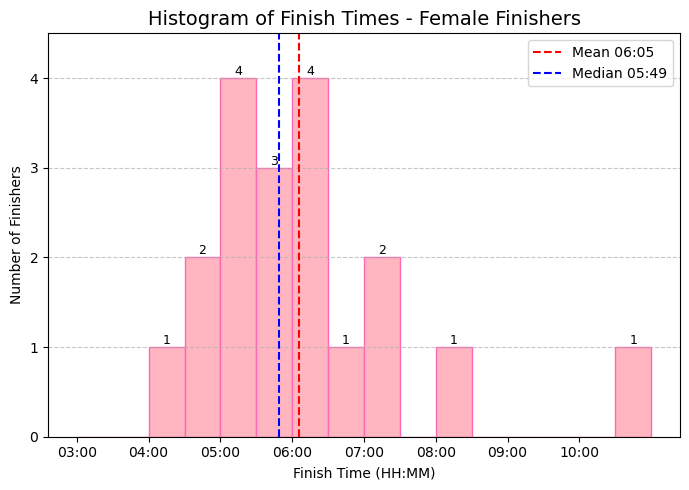

In [74]:
from matplotlib.ticker import MaxNLocator

# Create histogram
fig, ax = plt.subplots(figsize=(7, 5))
ax.yaxis.set_major_locator(MaxNLocator(integer=True)) # force axis ticks to display as integers

# Define bins
bins = np.arange(3 * 3600, 11 * 3600 + 1, 1 * 3600 / 2)

# Plot histogram and get the bar values
counts, bins, patches = ax.hist(
    female_finishers['Finish Time (seconds)']
    , bins=bins
    , color='lightpink'
    , edgecolor='hotpink'
)

# Format x-axis ticks from seconds to HH:MM
tick_locs = np.arange(3 * 3600, 11 * 3600, 3600)
ax.set_xticks(tick_locs)
ax.xaxis.set_major_formatter(FuncFormatter(seconds_to_hhmm))

# Add mean and median vertical lines
plt.axvline(female_mean, color='red', linestyle='--', linewidth=1.5, label=f'Mean {seconds_to_hhmm(female_mean)}')
plt.axvline(female_median, color='blue', linestyle='--', linewidth=1.5, label=f'Median {seconds_to_hhmm(female_median)}')

# Add data lables 
plt.bar_label(patches, labels=[f'{int(p.get_height())}' if p.get_height() != 0 else '' for p in patches], fontsize=9)

# Title and labels
ax.set_title('Histogram of Finish Times - Female Finishers', fontsize=14)
ax.set_xlabel('Finish Time (HH:MM)')
ax.set_ylabel('Number of Finishers')
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_ylim(0, 4.5)

plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.savefig("Histogram of Finish Times - Female Finishers.png", dpi=300, bbox_inches='tight')  # High resolution, no extra whitespace
plt.show()

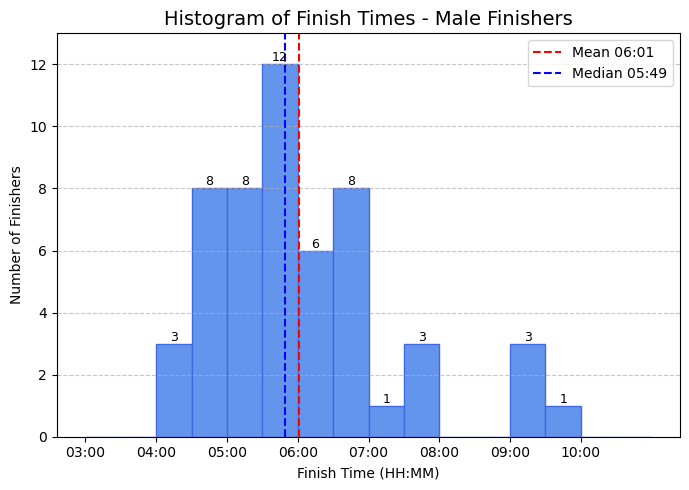

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Create histogram
fig, ax = plt.subplots(figsize=(7, 5))

# Define bins
bins = np.arange(3 * 3600, 11 * 3600 + 1, 1 * 3600 / 2)

# Plot histogram and get the bar values
counts, bins, patches = ax.hist(
    male_finishers['Finish Time (seconds)']
    , bins=bins
    , color='cornflowerblue'
    , edgecolor='royalblue')

# Format x-axis ticks from seconds to HH:MM
tick_locs = np.arange(3 * 3600, 11 * 3600, 3600)
ax.set_xticks(tick_locs)
ax.xaxis.set_major_formatter(FuncFormatter(seconds_to_hhmm))

# Add mean and median vertical lines
plt.axvline(male_mean, color='red', linestyle='--', linewidth=1.5, label=f'Mean {seconds_to_hhmm(male_mean)}')
plt.axvline(male_median, color='blue', linestyle='--', linewidth=1.5, label=f'Median {seconds_to_hhmm(male_median)}')

# Add data lables 
plt.bar_label(patches, labels=[f'{int(p.get_height())}' if p.get_height() != 0 else '' for p in patches], fontsize=9)

# Labels and grid
ax.set_title('Histogram of Finish Times - Male Finishers', fontsize=14)
ax.set_xlabel('Finish Time (HH:MM)')
ax.set_ylabel('Number of Finishers')
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_ylim(0, 13)

plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.savefig("Histogram of Finish Times - Male Finishers.png", dpi=300, bbox_inches='tight')  # High resolution, no extra whitespace
plt.show()

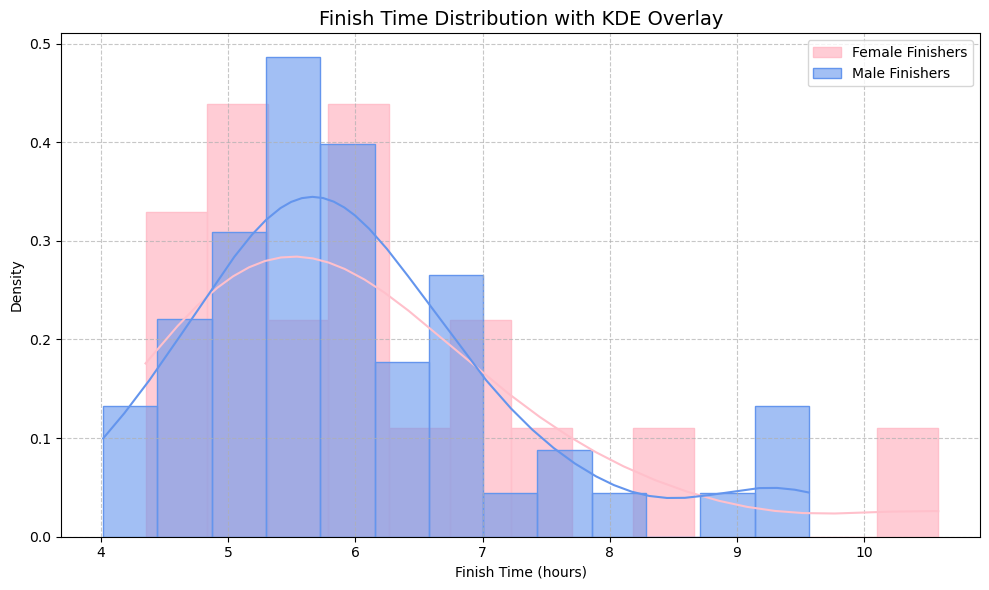

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert Finish (seconds) to hours for easier x-axis interpretation
female_finish_times = female_finishers['Finish Time (seconds)'] / 3600
male_finish_times = male_finishers['Finish Time (seconds)'] / 3600

# Plot
plt.figure(figsize=(10,6))

sns.histplot(female_finish_times, kde=True
             , color='pink', edgecolor='pink'
             , label='Female Finishers'
             , bins=13, stat='density', alpha=0.8)
sns.histplot(male_finish_times, kde=True
             , color='cornflowerblue', edgecolor='cornflowerblue'
             , label='Male Finishers'
             , bins=13, stat='density', alpha=0.6)

# Title and labels
plt.title('Finish Time Distribution with KDE Overlay', fontsize=14)
plt.xlabel('Finish Time (hours)')
plt.ylabel('Density')

plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [20]:
finishers_division_mean = (finishers_2025_df.groupby(['Division', 'Sex'], observed=True)[['Finish Time (seconds)']].mean()
                          .reset_index()
                          .pivot(index='Division', columns='Sex', values='Finish Time (seconds)')
                          .rename_axis(None, axis=1)
                          .reset_index()
                         )
finishers_division_mean

,Division,F,M
0,18 - 29,18580.0,20145.000000
1,30 - 39,22420.0,20022.857143
2,40 - 49,20740.0,21502.105263
3,50 - 59,21720.0,20745.000000
4,60 - 69,28580.0,26280.000000
5,80 - Up,NaN,32700.000000


In [21]:
finishers_division_std = (finishers_2025_df.groupby(['Division', 'Sex'], observed=True)[['Finish Time (seconds)']].std()
                          .reset_index()
                          .pivot(index='Division', columns='Sex', values='Finish Time (seconds)')
                          .rename_axis(None, axis=1)
                          .reset_index()
                         )
finishers_division_std

,Division,F,M
0,18 - 29,2531.639785,4518.732439
1,30 - 39,4322.221651,3079.879404
2,40 - 49,4622.142360,3737.657583
3,50 - 59,NaN,3647.605690
4,60 - 69,8287.243209,7028.866196
5,80 - Up,NaN,NaN


In [22]:
finishers_division_count = (finishers_2025_df.groupby(['Division', 'Sex'], observed=False).size()
                            .unstack()
                            .reset_index()
                           )
finishers_division_count

Sex,Division,F,M
0,18 - 29,3,8
1,30 - 39,3,7
2,40 - 49,9,19
3,50 - 59,1,12
4,60 - 69,3,6
5,80 - Up,0,1


### Standard Deviation Analysis

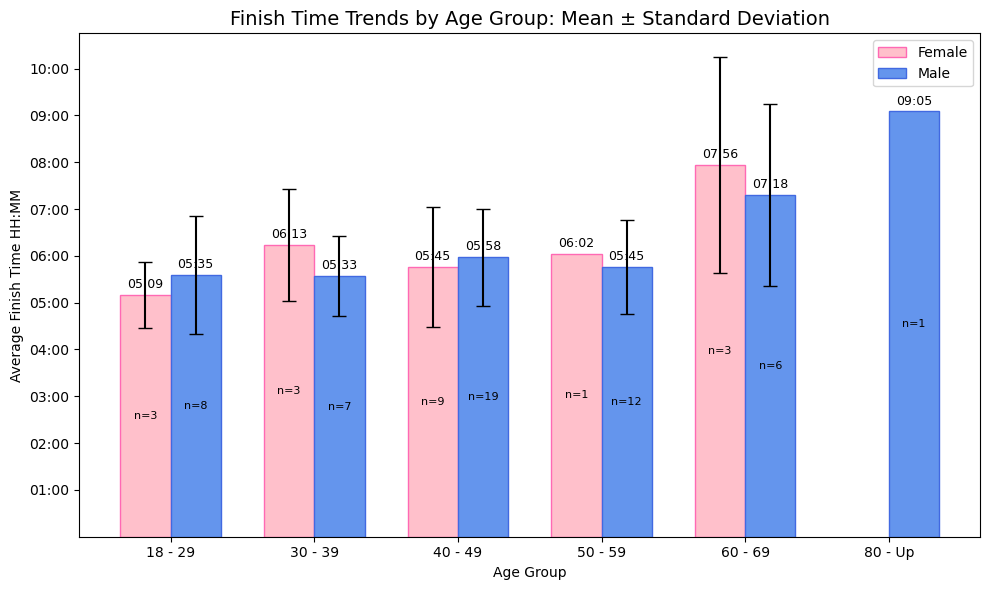

In [75]:
# Set width and position for bars
bar_width = 0.35
x = np.arange(len(finishers_division_mean['Division']))

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars
bars1 = ax.bar(x - bar_width/2
               , finishers_division_mean['F']
               , yerr=finishers_division_std['F']
               , width=bar_width, label='Female', color='pink', edgecolor='hotpink'
               , capsize=5)
bars2 = ax.bar(x + bar_width/2
               , finishers_division_mean['M']
               , yerr=finishers_division_std['M']
               , width=bar_width, label='Male', color='cornflowerblue', edgecolor='royalblue'
               , capsize=5)

# Format y-axis ticks from seconds to HH:MM
tick_locs = np.arange(1 * 3600, 11 * 3600, 3600)
ax.set_yticks(tick_locs)
ax.yaxis.set_major_formatter(FuncFormatter(seconds_to_hhmm))
ax.set_xticks(x)
ax.set_xticklabels(finishers_division_mean['Division'])

# Add data labels
# Average Finish Time
for bar in bars1 + bars2:
    height = bar.get_height()
    if not np.isnan(height):
        ax.text(bar.get_x() + bar.get_width()/2, height + 300, f'{seconds_to_hhmm(height)}', ha='center', va='bottom', fontsize=9)
# Age Group Count
ax.bar_label(bars1
             , labels=[f'n={int(val)}' if not np.isnan(val) else '' for val in finishers_division_count['F']]
             , label_type='center', fontsize=8, color='black'
            )
ax.bar_label(bars2
             , labels=[f'n={int(val)}' if not np.isnan(val) else '' for val in finishers_division_count['M']]
             , label_type='center', fontsize=8, color='black'
            )

# Title and Labels
ax.set_title('Finish Time Trends by Age Group: Mean ± Standard Deviation', fontsize=14)
ax.set_xlabel('Age Group')
ax.set_ylabel('Average Finish Time HH:MM')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig("Finish Time Trends by Age Group: Mean ± Standard Deviation.png", dpi=300, bbox_inches='tight')  # High resolution, no extra whitespace

plt.show()

In [24]:
# Calculate Coefficient of Variation CV = std / mean
cv_df = finishers_division_std.copy()
cv_df['Female'] = finishers_division_std['F'] / finishers_division_mean['F']
cv_df['Male'] = finishers_division_std['M'] / finishers_division_mean['M']
cv_df = cv_df.drop(['F', 'M'], axis=1)
cv_df

,Division,Female,Male
0,18 - 29,0.136256,0.224310
1,30 - 39,0.192784,0.153818
2,40 - 49,0.222861,0.173828
3,50 - 59,NaN,0.175831
4,60 - 69,0.289967,0.267461
5,80 - Up,NaN,NaN


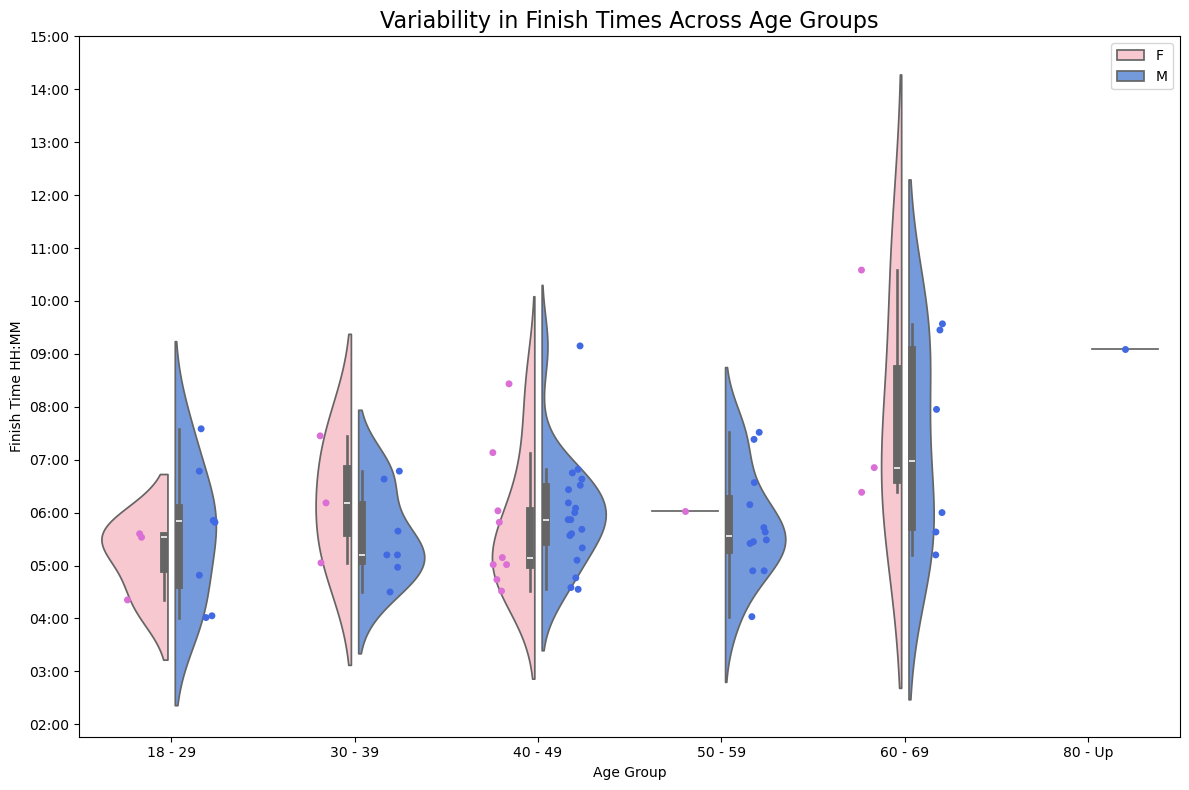

In [25]:
# Create violin plot
fig, ax = plt.subplots(figsize=(12, 8))

sns.violinplot(data=finishers_2025_df, x='Division', y='Finish Time (seconds)'
               , hue='Sex', split=True, gap=.1
               , palette={'M': 'cornflowerblue', 'F': 'pink'}
               # , fill=False
              )
sns.stripplot(data=finishers_2025_df, x='Division', y='Finish Time (seconds)'
              , hue='Sex', dodge=True, legend=False
              , palette={'M': 'royalblue', 'F': 'orchid'})

# Format y-axis ticks from seconds to HH:MM
tick_locs = np.arange(2 * 3600, 16 * 3600, 3600)
ax.set_yticks(tick_locs)
ax.yaxis.set_major_formatter(FuncFormatter(seconds_to_hhmm))

# Title and Labels
ax.set_title('Variability in Finish Times Across Age Groups', fontsize=16)
ax.set_xlabel('Age Group')
ax.set_ylabel('Finish Time HH:MM')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('violinchart.png', dpi=300, bbox_inches='tight')
plt.show()
